# Invasive Ductal Carcinoma Classification


ABSTRACT:

The assigned original project focused on leveraging the fastai library, a Python deep learning framework built on PyTorch, for the classification of breast histopathology images. The Kaggle dataset utilized contained over 400,000 images categorized into class 0 (healthy tissues) and class 1 (diseased). To handle this data, loading procedures considered validation percentages, defined augmentation criteria, and established an ImageDataBunch. A transfer learning strategy was adopted, employing a pre-trained ResNet18 Convolutional Neural Network from the ImageNet database. Fine-tuning involved adjusting the weights of the last layers along with the learning rate parameter, resulting in an impressive 89% accuracy.

The project showcased the efficacy of transfer learning and data augmentation but faced limitations, including an outdated fastai library version, interpretability challenges due to Fastai's high-level abstractions, class distribution imbalance, and absence of a dedicated test set, raising concerns about model generalization.

To address these limitations, the current project endeavours to:

- Transition from fastai to Keras for building, training, and deploying the neural network.

- Mitigate class imbalance by introducing weights that prioritize accurate classification of class 1.

- Allocate 15% of the dataset for comprehensive testing, adjusting the training-evaluating-test set percentages to 70-15-15%.

- Explore the potential advantages of ResNet50 over ResNet18 and compare their performances with a transfer learning model built upon Efficient Net, as covered in theoretical lessons.


# ANALYSIS OF THE ORIGINAL WORK WITH FASTAI

In this section we will provide a short comment on the most relevant parts of the original project in fastai. We decided to create this section since our code was implemented in keras, following the same pipeline of the original one, but making it impossible to comment the code in a parallel way.

DATA PREPARATION:
In this part a path, in order to read the images, is created, alongside the pattern to give to the ImageDataBunch. Moreover, the data augmentation function to use afterwards is created: it applies a random horizontal or vertical flip in the 50% of the cases and random change of brightness and contrast. The possibilities of rotating, flipping and zooming have been removed.

In [ ]:
"""
path='/content/data/'
pattern= r'([^/_]+).png$'
fnames=get_files(path, recurse=True)
tfms=aug_transforms(flip_vert=True, max_warp=0., max_zoom=0., max_rotate=0.)
!ls /content/data """

DATA LOADING FOR TRAINING: a dataset is created from the path and the pattern of choice and the defined data augmentation method.The image dimension is reduced from 224x224 to 50x50 pixels and the dataset is normalized. ImageDataBuch also splits the data in training and validation set with proportion 0.8/0.2.


In [ ]:
"""
np.random.seed(40)
dls = ImageDataLoaders.from_name_re(path, fnames, pattern, ds_tfms=tfms, item_tfms=CropPad(50))
dls.show_batch(figsize=(9,9))
"""

MODEL CREATION: the pretrained model is loaded and applied to the dataset previously created, using accuracy as evaluation metric. It uses the old version of the vision_learner function.

In [ ]:
"""learn = vision_learner(dls, xresnet18, metrics=[accuracy], normalize=True)"""

MODEL TRAINING: a build-in fastai function is used to tune the learning rate parameter. This function plots the learning rate values and the corresponding loss obtained by training the model, so that it is possible to choose the optimal value by visual inspection. The function learn.fit_one_cycle(1,slice(lr)) computes then the optimal model parameters by employing the 1cycle policy, which is a method that allows to train the neural networks in a very quick way by using high learning rates.


In [ ]:
"""
learn.lr_find()
lr1 = 1e-3
lr2 = 1e-1
learn.fit_one_cycle(1,slice(lr1,lr2))
lr = 1e-1
learn.fit_one_cycle(1,slice(lr))
"""

UNFREEZING THE MODEL: now the parameters of the pretrained model are unfreezed. The learning rate is tuned again, with lower values. The losses are then plotted in relation of the number of batches considered.


In [ ]:
"""
learn.unfreeze()
learn.lr_find()
learn.fit_one_cycle(1,slice(1e-4,1e-3),cbs=[ShowGraphCallback()])
learn.recorder.plot_losses()
"""

RESULTS VISUALIZATION:
A interp object is created according to the learner, which provides information such as the employed model, the ds index and the dataloader used to make predictions. The confusion matrix is then plotted and the model is saved.


In [ ]:
"""
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(normalize=True)
learn.export()
learn.model_dir = "content/results/"
learn.save("stage-1")"""

# OUR PROJECT



STEP 1: importing all the libraries necessary for the development of the following work.

ORIGINAL PROJECT: it imported fastai

OUR PROJECT: we build our neural networks using keras


In [ ]:
# libraries to interface with the os
import os
from os.path import join
from glob import glob

# standard scientific libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid", font_scale=1.5)

# progress bar
from tqdm.autonotebook import tqdm

# there are many libraries to handle images
import cv2 as cv # open-cv
#from PIL import Image # PIL
# also keras as built-in functions to load images and convert to arrays

# tensorflow utilities
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix

<ipython-input-1-c729136517f0>:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


We are now deciding how to manage the GPU in order to be more efficient:

In [ ]:
# tensorflow by default uses all the memory available in gpu

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Found {len(gpus)} GPU")
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


Found 1 GPU


We are now importing the provided dataset from google drive.

In [ ]:
# mount Google Drive Folder
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
os.getcwd()

'/content'

In [ ]:
# change this accordingly to your path in gdrive
%cd "/content/drive/MyDrive/HW"

/content/drive/.shortcut-targets-by-id/1zMu8TorOi7CkEu2woieDFJV8Jy6AK_sW/HW


## Dataset Description

## Dataset Description

The original dataset consists of 162 whole mount slide images of Breast Cancer (BCa) specimens scanned at 40x. From that, 277,524 patches of size 50 x 50 were extracted (198,738 IDC negative and 78,786 IDC positive). Each patch’s file name is of the format: u_xX_yY_classC.png — > example 10253_idx5_x1351_y1101_class0.png . Where u is the patient ID (10253_idx5), X is the x-coordinate of where this patch was cropped from, Y is the y-coordinate of where this patch was cropped from, and C indicates the class where 0 is non-IDC and 1 is IDC.

To go into more detail, from inspection of the provided dataset, we notice the following factors:

 All the data are organized in directories corresponding to the subjects analysed. In each parent directory, there are two directories containing, respectively, samples of healthy and diseased tissue. The numerosity of samples is heterogeneous across subjects.

 Moreover, an additional directory is present, having inside itself the copy of all the files of all subjects. Acknowledging the fact that the data are the same, we decide to not consider them, therefore our dataset has half the samples of the original employed one. This is proved true by the fact that the description of the dataset mentions 277,524 patches while in the original project the number employed is, strangely, the double.

In [ ]:
from zipfile import ZipFile    #we load the content of the zip file

with ZipFile("archive.zip", "r") as f:
    f.extractall("/content/")

In [ ]:
!ls /content  #in order to see what there is inside the file

10253  10288  12810  12881  12930  13403  14153  15513	16554  8980  9174  9291
10254  10290  12811  12882  12931  13404  14154  15514	16555  8984  9175  9319
10255  10291  12817  12883  12932  13458  14155  15515	16568  9022  9176  9320
10256  10292  12818  12884  12933  13459  14156  15516	16569  9023  9177  9321
10257  10293  12819  12886  12934  13460  14157  15632	16570  9029  9178  9322
10258  10295  12820  12890  12935  13461  14188  15633	16895  9035  9181  9323
10259  10299  12821  12891  12947  13462  14189  15634	16896  9036  9225  9324
10260  10300  12822  12892  12948  13591  14190  15839	8863   9037  9226  9325
10261  10301  12823  12893  12949  13613  14191  15840	8864   9041  9227  9344
10262  10302  12824  12894  12951  13616  14192  15902	8865   9043  9228  9345
10264  10303  12826  12895  12954  13617  14209  15903	8867   9044  9250  9346
10268  10304  12867  12896  12955  13666  14210  16014	8913   9073  9254  9347
10269  10305  12868  12897  13018  13687  14211  160

In the following section we are addressing one of the limitations of the original work, which was the lack of an independent test set. We are creating a training set containing 70% of the data and a validation and a test set each containing 15% of data. In the original work, the data were divided into 80% of training set and 20% of validation set.

We paid particular attention to the following aspect: in dividing into subsets, we didn't merge files belonging to the same subject. This means that a subject is only present in one and only subset between training, validation and test sets. This is necessary to avoid possible dangerous correlations across samples which could mine the independence of the subsets, leading in biased results.

In [ ]:
# Train and test splitting but dividing the patients images without mixing them in train and test

list_train_ID=list()  #list of patient in trainset(and val)
list_test_ID=list()
list_val_ID=list()
size_test=0 #inizialize variable useful for dividing into train and test
size_val=0
size_train=0
train_test_split=0.10
train_val_split=0.20

size_tot_ds=277524  #from dataset description


import shutil
import random
tags=os.listdir('/content')
random.shuffle(tags)

for i in tags:
    if i.isdigit() and size_test<(train_test_split*size_tot_ds):  #in order to take near the 0.x of the tot size for the test split
        shutil.copytree('/content/'+i+'/0','/data/test/0',dirs_exist_ok=True)
        shutil.copytree('/content/'+i+'/1','/data/test/1',dirs_exist_ok=True)
        list_test_ID.append(i)
        size_test+=len(os.listdir('/content/'+str(i)+'/0'))+len(os.listdir('/content/'+str(i)+'/1'))
    elif i.isdigit() and size_val < (train_val_split * size_tot_ds ):
        shutil.copytree('/content/' + i + '/0', '/data/val/0', dirs_exist_ok=True)
        shutil.copytree('/content/' + i + '/1', '/data/val/1', dirs_exist_ok=True)
        list_val_ID.append(i)
        size_val += len(os.listdir('/content/' + str(i) + '/0')) + len(os.listdir('/content/' + str(i) + '/1'))
    elif i.isdigit():
        shutil.copytree('/content/' + i + '/0', '/data/train/0', dirs_exist_ok=True)
        shutil.copytree('/content/' + i + '/1', '/data/train/1', dirs_exist_ok=True)
        list_train_ID.append(i)
        size_train += len(os.listdir('/content/' + str(i) + '/0')) + len(os.listdir('/content/' + str(i) + '/1'))

print(f"Size of the test set expected (almost): {train_test_split * size_tot_ds}\n")
print(f"Size of the test set created: {size_test}\n")
print(f"Size of the validation set created: {size_val}\n")
print(f"Size of the train set created: {size_train}\n")
print("\nList of test set patients\n")
print(list_test_ID)
print("\nList of validation set patients\n")
print(list_val_ID)
print("\nList of train set patients\n")
print(list_train_ID)


train_dir = '/data/train'
val_dir = '/data/val'
test_dir = '/data/test'

Size of the test set expected (almost): 27752.4

Size of the test set created: 28601

Size of the validation set created: 56803

Size of the train set created: 192120


List of test set patients

['16014', '15514', '15471', '10275', '10254', '14153', '9226', '10278', '12897', '12626', '12752', '13688', '9125', '10279', '9347', '10306', '16568', '9227', '12890', '12750', '9266', '12749', '9254', '16570', '13019', '12751', '13616']

List of validation set patients

['12878', '14155', '15510', '10305', '15633', '16569', '9255', '10260', '13403', '10285', '9261', '8984', '14188', '12879', '14212', '12900', '12882', '9259', '12870', '13613', '10290', '13689', '13018', '9319', '13404', '13458', '14156', '12872', '9262', '10302', '13691', '14082', '13025', '9323', '12949', '14192', '12901', '9383', '16532', '9022', '8865', '16553', '10292', '15516', '12948', '14210', '9076', '9043', '9260', '12893', '8957', '12242', '12895', '13916', '10264', '10256', '9178', '14209', '9321', '9124', '9267', 

In [ ]:
os.listdir('/data/val')

['0', '1']

In [ ]:
classes = sorted([f for f in os.listdir(train_dir) if f.isdigit()])

# let's create a dictionary where:
# - keys are folder names (-> the 2 classes)
# - values are the filenames for the files in each folder
imgs = {c: glob(join(train_dir, c, "*")) for c in classes}


We are now loading some images and plotting them to have a hint about the data.

In [ ]:
def load_image(fname):
    """
    Load an image using opencv given its path.
    """
    # img is a numpy array
    img = cv.imread(fname)
    # opencv uses BGR channel order by default
    # so convert to RGB
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    return img

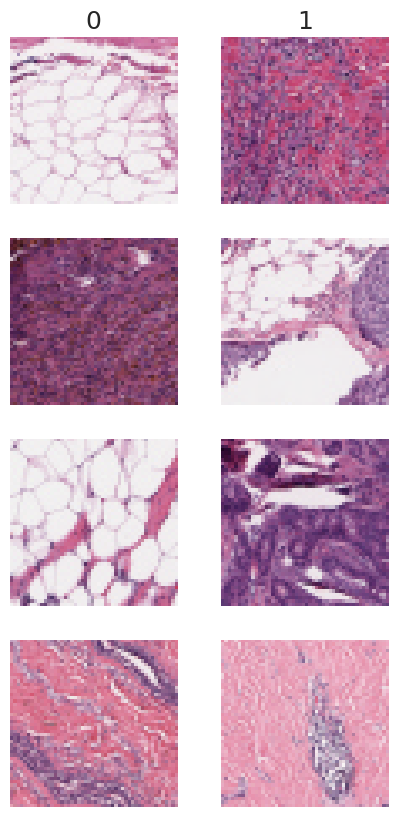

In [ ]:
# plot some images per class

nrows = 4

fig, axs = plt.subplots(nrows=4, ncols=len(classes), figsize=(5, 10))

for i,(c,fnames) in enumerate(imgs.items()):
    axs[0,i].set_title(c)
    for n in range(nrows):
        im = load_image(fnames[n])
        axs[n,i].imshow(im)

for ax in axs.flatten():
    ax.axis("off")


In [ ]:
# Here we check if the images are loaded in float form [0,1] or uint form [0,255]

X = load_image(imgs["0"][0])

print("Image dtype ="    , X.dtype)
print("Min pixel value =", X.min())
print("Max pixel value =", X.max())
print("Shape =", X.shape)

Image dtype = uint8
Min pixel value = 43
Max pixel value = 247
Shape = (50, 50, 3)


In the following section we are addressing the problem of class imbalance by adding weights that that prioritize accurate classification of class 1 (the diseased tissues), which is the class with lower sample numerosity.

In [ ]:
#Weight Dict
weights = (len(os.listdir(train_dir+'/0')) + len(os.listdir(train_dir+'/1'))) / np.array([len(os.listdir(train_dir+'/0')),len(os.listdir(train_dir+'/1'))])
weights = {c:w for c,w in enumerate(weights)}
print(f"Class weights = {weights}")

Class weights = {0: 1.3852276987857988, 1: 3.595867335479524}


We are now creating the datasets with a Dataloader (in our case by means of a build-in Keras utility which generates a dataset from image files in a directory) in order to load the data in memory only when needed. This improves the computational efficiency of the code.

We decided to go for a batch size equal to 64 to match the original project. Moreover, we resize the images to dimension 50x50, as done in the original work.

At the end we plot some images belonging to the validation dataset.

In [ ]:
SIZE = (50, 50) #set the size of youru image (h,w) #ResNet requires these dimensions

train_ds = keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="binary", #for multiclass="categorical", for binaryclass="binary"
    color_mode="rgb",
    batch_size=64,
    image_size=SIZE,
    shuffle=True, #to shuffle data independly on the order(doesn't understand by the order)
    seed=100,
)

val_ds = keras.preprocessing.image_dataset_from_directory(
    val_dir,
    labels="inferred",
    label_mode="binary", #for multiclass="categorical", for binaryclass="binary"
    color_mode="rgb",
    batch_size=64,
    image_size=SIZE,
    shuffle=True,
    seed=100,
)


test_set= keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="binary", #for multiclass="categorical", for binaryclass="binary"
    color_mode="rgb",
    batch_size=64,
    image_size=SIZE,
    shuffle=True,
    seed=100,
)

labels_map = {i:c for i,c in enumerate(train_ds.class_names)}

Found 192120 files belonging to 2 classes.
Found 56803 files belonging to 2 classes.
Found 28601 files belonging to 2 classes.


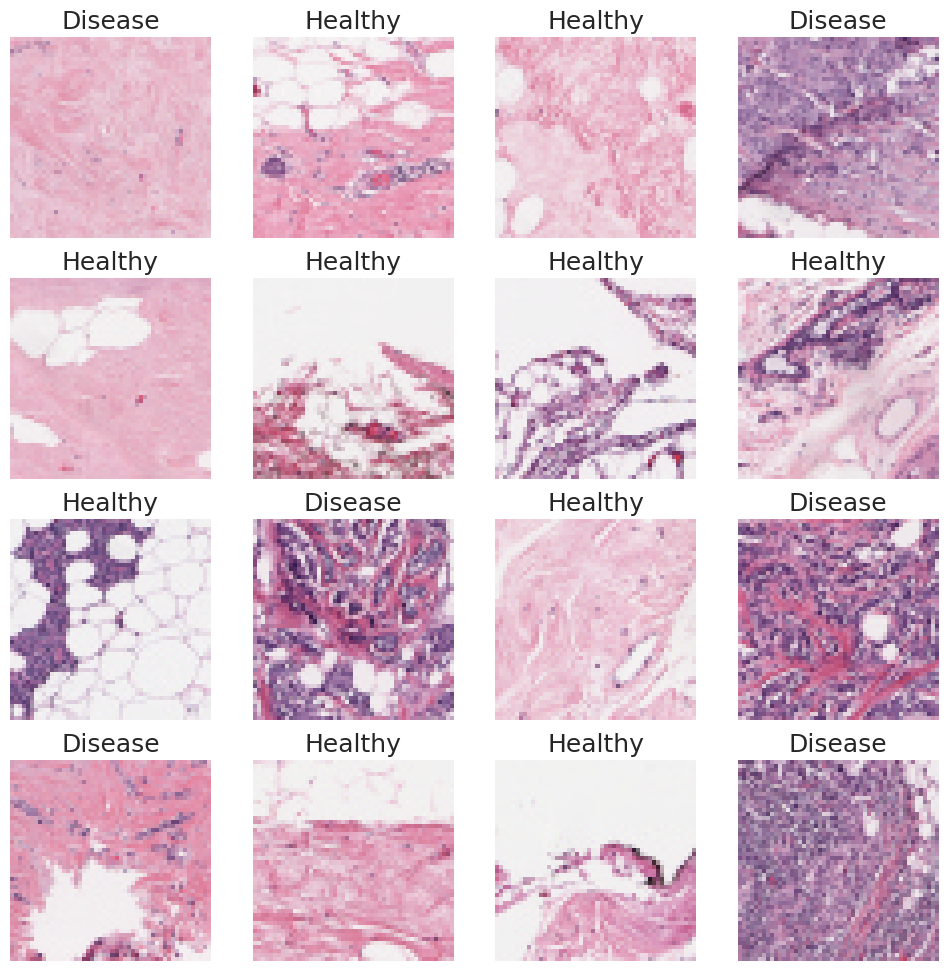

In [ ]:
plt.figure(figsize=(12, 12))
for images, labels in val_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        #title = labels_map[int((labels[i].numpy()))]
        title = "Healthy" if labels[i].numpy() == 0 else "Disease"
        plt.title(title)
        plt.axis("off")



## Data Augmentation and Preprocessing


We are here applying a preprocessing step in which we scale the pixels values into the raneg [0,1].

In [ ]:
preprocessing = keras.Sequential(
    [
        layers.Rescaling(1./255.) # rescale pixels in [0,1]
     ]
)

We are now using the data augmentation technique in order to reduce the risk of overfitting and improving the model's generalization, In the data augmentation we are augmenting images by randomly flipping, rotating and zooming them. A similar step was done in the original work, were a random flip was applied in the 50% of the cases, alongside with random changes of constrast and brightness of the images. In both cases, the analysis conducted on the augmented dataset will improve the model robustness.

After this step, we plotted some of the augmented data to ensure that everything went as it should.


In [ ]:

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip(), #flip image
        layers.RandomRotation(.3),  #rotate
        layers.RandomZoom(height_factor=(-.5,0), fill_mode="constant"), #scale
    ]
)

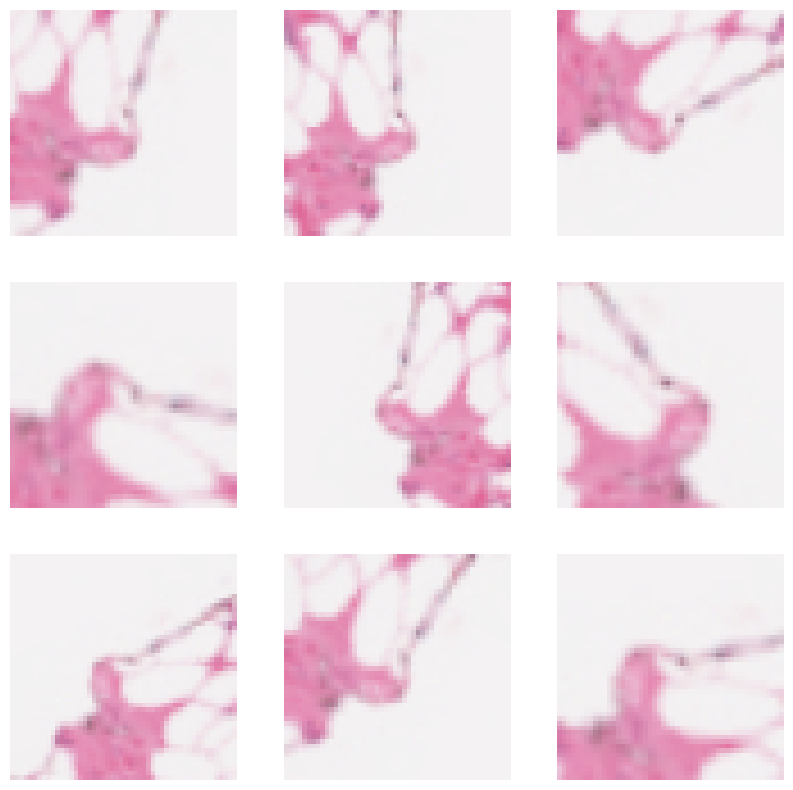

In [ ]:
# Visualize an example of data augmentatation

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


We use prefetching methods in order to reduce the overall training time and improving the efficiency of the code.

In [ ]:
# Let's make sure to use buffered prefetching so we can yield data from disk
# without having I/O becoming blocking

train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

## Transfer Learning using ResNet50 model as a backbone

Transfer learning consists of taking features learned on one problem by a pretrained network, and leveraging them on a new, similar problem. It is a very common tecnique in ML, since it allows to obtain very good results even when you do not have lots of data. Pretrained networks usually consists on a convolution part, followed by a fully connected top (used for the task the network was trained on). We just take the convolutional part, freezing the weights so they are not updated during training, and then we attach a custom head to be trained on our specific task.

In our case we decide to use ResNet50 as a backbone of our neural network, while in the original project a ResNet18 model was employed. The main difference between ResNet18 and ResNet50 lies in their depth, i.e., the number of layers, which is 18 in the first case and 50 in the second case. Due to its increased depth, ResNet50 is generally more powerful and has the potential to capture more complex features compared to ResNet18.


First of all, we decide the metrics used to evaluate the model, we define the learning rate scheduler and the callbacks.

ORIGINAL WORK: in the original work, a fine-tuning of the learning parameter was done with a build-in function provided by the fastai library.

OUR WORK: In our case, we use the adam adaptive learning rate optimization algorithm and we decrease its value after the tenth epoch, multiplying it by 0.95. We've seen that the model performances are comparable even without tuning the learning rate parameter as done by the fastai build-in function.

In [ ]:
def lr_scheduler(epoch,lr):
    if epoch < 10:
      return lr
    else:
      return lr*0.95

callbacks = [
          # early stopping on validation loss
          keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
          # reduce lr if there are no improvements
          keras.callbacks.LearningRateScheduler(lr_scheduler)
          #keras.callbacks.ReduceLROnPlateau(patience=5, factor=.5)
            ]

We now import the ResNet50 model.

In order to make sure that the preprocessing of the images is the one expected by the ResNet50 model, we import from the package also the preprocess_input function that applies the right preprocessing to the images.


In [ ]:
# RES NET IMPLEMENTATION
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input


#input shape
input_shape = SIZE + (3,)
# adding some metrics to monitor during training
metrics_names = ["accuracy", "auc"]
metrics = ["accuracy", keras.metrics.AUC(name="auc")]


# Load pre-trained ResNet50 model
# the SIZE parameter at the beginning of the code must be set properly

def transfer_learning_ResNet50(input_shape, num_class=2):

    inputs = layers.Input(input_shape)
    x = data_augmentation(inputs) # what we did before
    # adding here the correct preprocessing function
    # I import it from the package, and it includes:
    # Normalization: Normalize the pixel values to be in the range of [0, 1] or [-1, 1].
    x = preprocess_input(inputs)

    # load the pretrained net, without the final layers
    backbone = ResNet50(include_top=False, input_tensor=x, weights="imagenet",input_shape=(224, 224, 3))
    # freeze pretrained network
    backbone.trainable = False #doesn't have to update the backbone which is already trained

    # add top for fine tuning for our specific task
    x = layers.GlobalAveragePooling2D()(backbone.output)
    x = layers.Dropout(.25)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(.25)(x)
    # in case of binary classification here I can just have 1 unit with sigmoid activation
    if num_class == 2:
        out = layers.Dense(1, activation="sigmoid")(x)
    else:
        out = layers.Dense(num_class, activation="softmax")(x)

    # create the whole model (pretrained ResNet50 + custom head)
    model = keras.Model(inputs=inputs, outputs=out)

    return model


We create the model as previously stated and we plot it.

94765736/94765736 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 50, 50, 3)]          0         []                            
                                                                                                  
 tf.__operators__.getitem (  (None, 50, 50, 3)            0         ['input_1[0][0]']             
 SlicingOpLambda)                                                                                 
                                                                                                  
 tf.nn.bias_add (TFOpLambda  (None, 50, 50, 3)            0         ['tf.__operators__.getitem[0][
 )                                                                  0]']                          
                             

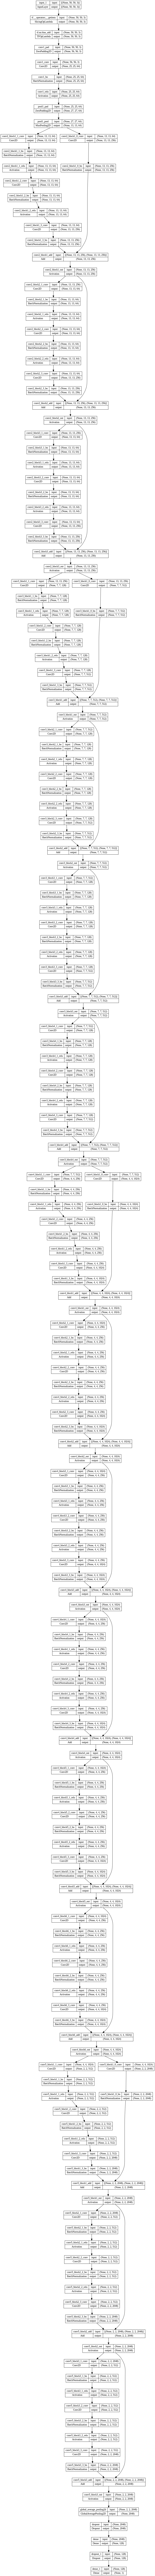

In [ ]:
t1_model = transfer_learning_ResNet50(input_shape, num_class=2)

t1_model.summary()
keras.utils.plot_model(t1_model, to_file="transfer_learning_ResNet50.png", show_shapes=True)


We now train the model:

In [ ]:
t1_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=metrics)
history = t1_model.fit(train_ds, epochs=20, callbacks=callbacks, validation_data=val_ds, class_weight=weights)

Epoch 1/20
3002/3002 [==============================] - 58s 16ms/step - loss: 0.8424 - accuracy: 0.8180 - auc: 0.8905 - val_loss: 0.3884 - val_accuracy: 0.8275 - val_auc: 0.8993 - lr: 0.0010
Epoch 2/20
3002/3002 [==============================] - 47s 16ms/step - loss: 0.7854 - accuracy: 0.8301 - auc: 0.9049 - val_loss: 0.4097 - val_accuracy: 0.8141 - val_auc: 0.8975 - lr: 0.0010
Epoch 3/20
3002/3002 [==============================] - 47s 16ms/step - loss: 0.7712 - accuracy: 0.8328 - auc: 0.9085 - val_loss: 0.3967 - val_accuracy: 0.8225 - val_auc: 0.8973 - lr: 0.0010
Epoch 4/20
3002/3002 [==============================] - 47s 16ms/step - loss: 0.7578 - accuracy: 0.8375 - auc: 0.9119 - val_loss: 0.4035 - val_accuracy: 0.8196 - val_auc: 0.8986 - lr: 0.0010
Epoch 5/20
3002/3002 [==============================] - 47s 16ms/step - loss: 0.7471 - accuracy: 0.8403 - auc: 0.9144 - val_loss: 0.3968 - val_accuracy: 0.8225 - val_auc: 0.9007 - lr: 0.0010
Epoch 6/20
3002/3002 [=======================

We now define the function plot_history (as seen in our laboratory lessons) in order to see how our metrics change during the training of the model. Afterwards, we use it to have a gasp of how things went, we execute validation and we save what we obtain.

In [ ]:
# let's define a function to plot metrics durin the training

def plot_history(history):

    if not isinstance(history, dict):
        history = history.history

    ncols = 4 if "lr" in history else 3

    fig, axs = plt.subplots(ncols=ncols, figsize=(30,5))


    for m,ax in zip(["loss", "accuracy", "auc"], axs):
        ax.plot(history[m], label=m)
        ax.plot(history[f"val_{m}"], label=f"val_{m}")
        ax.legend()
        ax.set_title(m)

    if "lr" in history:
        axs[-1].plot(history["lr"], label="lr")
        axs[-1].legend()
        axs[-1].set_title("lr")

    fig.tight_layout()

    return


888/888 [==============================] - 10s 11ms/step - loss: 0.3856 - accuracy: 0.8283 - auc: 0.9001


[0.385639488697052, 0.8283189535140991, 0.9001222848892212]

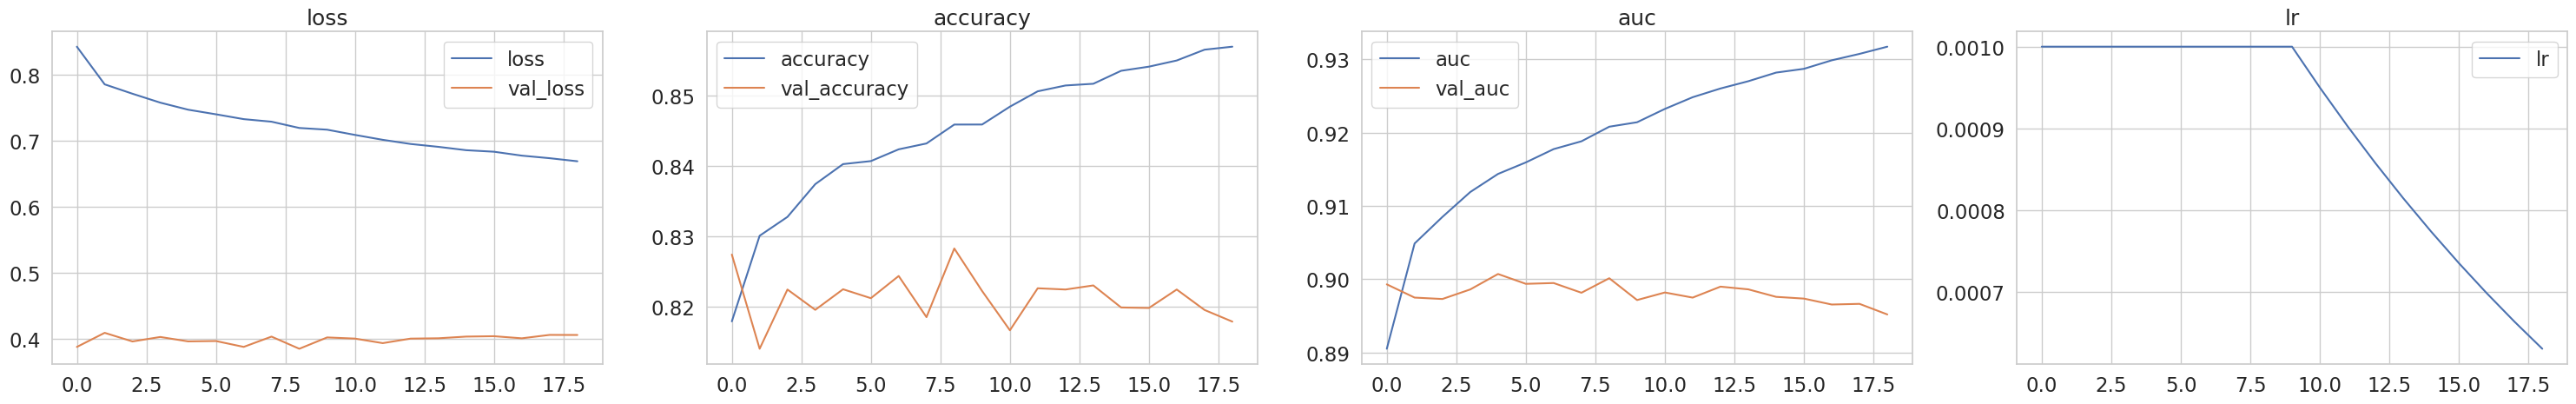

In [ ]:
plot_history(history.history)

t1_model.evaluate(val_ds)

In [ ]:
t1_model.save("models/TL_20epoch_ResNet_Size224_OB_test10.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Prediction on test set using transfer learning model based on ResNet50

We now see how the model we created performs on the test set.

In [ ]:
imgs, labels, preds = [], [], []

for img, label in test_set:
    pred = t1_model.predict(img)

    imgs.append(img.numpy())
    labels.append(label.numpy())
    preds.append(pred)


2/2 [==============================] - 1s 370ms/step


In [ ]:
# predictions are done in batches
imgs[0].shape

(64, 50, 50, 3)

In [ ]:
# concatenate arrays
imgs = np.concatenate(imgs).astype(np.uint8)
labels = np.concatenate(labels).squeeze()
preds = np.concatenate(preds).squeeze()

In [ ]:
classes = labels
pred_classes=np.zeros(shape=(len(preds),1),dtype=np.int8).squeeze()
pred_classes[preds>0.5] = int(1)


In [ ]:
# compute some metrics using sklearn

print(
    classification_report(
        classes, pred_classes,
        labels=list(labels_map.keys()),
        target_names=list(labels_map.values()), digits=3
    )
)

              precision    recall  f1-score   support

           0      0.889     0.882     0.885     19977
           1      0.732     0.744     0.738      8624

    accuracy                          0.841     28601
   macro avg      0.810     0.813     0.812     28601
weighted avg      0.841     0.841     0.841     28601



Text(145.75, 0.5, 'True')

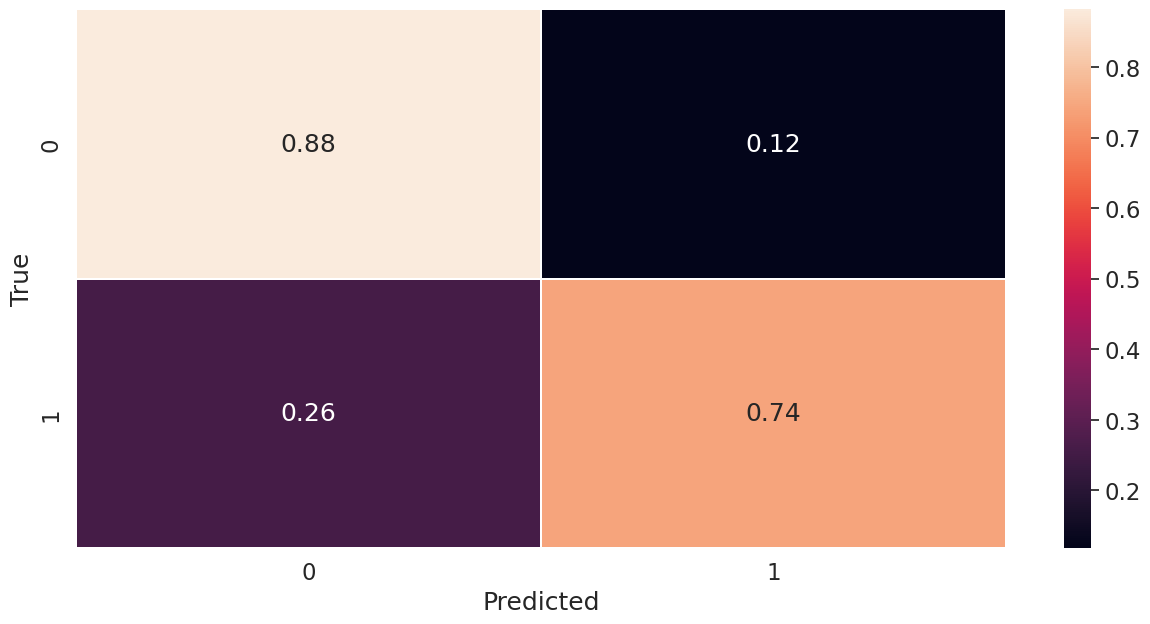

In [ ]:
# confusion matrix

cm = confusion_matrix(classes, pred_classes,normalize='true')

fif, ax = plt.subplots(figsize=(15,7))
sns.heatmap(cm, annot=True, linewidths=.1, xticklabels=list(labels_map.values()), yticklabels=list(labels_map.values()), ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")

# Unfreezing ResNet50

In this section, following the modus operandi of the original project, we try to unfreeze the ResNet50 parameters to see if there are valuable changes in the performances of the model. We train on 20 epochs. To avoid overfitting, we tried setting a smaller learning rate parameter.

In [ ]:
# unfreeze model
for layer in t1_model.layers:
  if not isinstance(layer, layers.BatchNormalization):
    layer.trainable = True

optimizer = tf.keras.optimizers.Adam(learning_rate=0.5e-4)
t1_model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=metrics)

In [ ]:
history = t1_model.fit(train_ds, epochs=20, validation_data=val_ds, class_weight=weights, callbacks=callbacks)

Epoch 1/20
3002/3002 [==============================] - 136s 39ms/step - loss: 0.6761 - accuracy: 0.8554 - auc: 0.9238 - val_loss: 0.4888 - val_accuracy: 0.7494 - val_auc: 0.9224 - lr: 5.0000e-05
Epoch 2/20
3002/3002 [==============================] - 116s 39ms/step - loss: 0.5958 - accuracy: 0.8711 - auc: 0.9457 - val_loss: 0.3520 - val_accuracy: 0.8401 - val_auc: 0.9295 - lr: 5.0000e-05
Epoch 3/20
3002/3002 [==============================] - 116s 39ms/step - loss: 0.5394 - accuracy: 0.8818 - auc: 0.9553 - val_loss: 0.3420 - val_accuracy: 0.8446 - val_auc: 0.9291 - lr: 5.0000e-05
Epoch 4/20
3002/3002 [==============================] - 120s 40ms/step - loss: 0.4846 - accuracy: 0.8923 - auc: 0.9635 - val_loss: 0.3522 - val_accuracy: 0.8593 - val_auc: 0.9258 - lr: 5.0000e-05
Epoch 5/20
3002/3002 [==============================] - 117s 39ms/step - loss: 0.4270 - accuracy: 0.9042 - auc: 0.9711 - val_loss: 0.5190 - val_accuracy: 0.8469 - val_auc: 0.9007 - lr: 5.0000e-05
Epoch 6/20
3002/3002

In [ ]:
imgs, labels, preds = [], [], []

for img, label in test_set:
    pred = t1_model.predict(img)

    imgs.append(img.numpy())
    labels.append(label.numpy())
    preds.append(pred)


2/2 [==============================] - 1s 11ms/step


In [ ]:
# predictions are done in batches
imgs[0].shape

(64, 50, 50, 3)

In [ ]:
# concatenate arrays
imgs = np.concatenate(imgs).astype(np.uint8)
labels = np.concatenate(labels).squeeze()
preds = np.concatenate(preds).squeeze()

In [ ]:
classes = labels
pred_classes=np.zeros(shape=(len(preds),1),dtype=np.int8).squeeze()
pred_classes[preds>0.5] = int(1)


In [ ]:
# compute some metrics using sklearn

print(
    classification_report(
        classes, pred_classes,
        labels=list(labels_map.keys()),
        target_names=list(labels_map.values()), digits=3
    )
)

              precision    recall  f1-score   support

           0      0.918     0.882     0.900     19977
           1      0.749     0.818     0.782      8624

    accuracy                          0.862     28601
   macro avg      0.834     0.850     0.841     28601
weighted avg      0.867     0.862     0.864     28601



Text(145.75, 0.5, 'True')

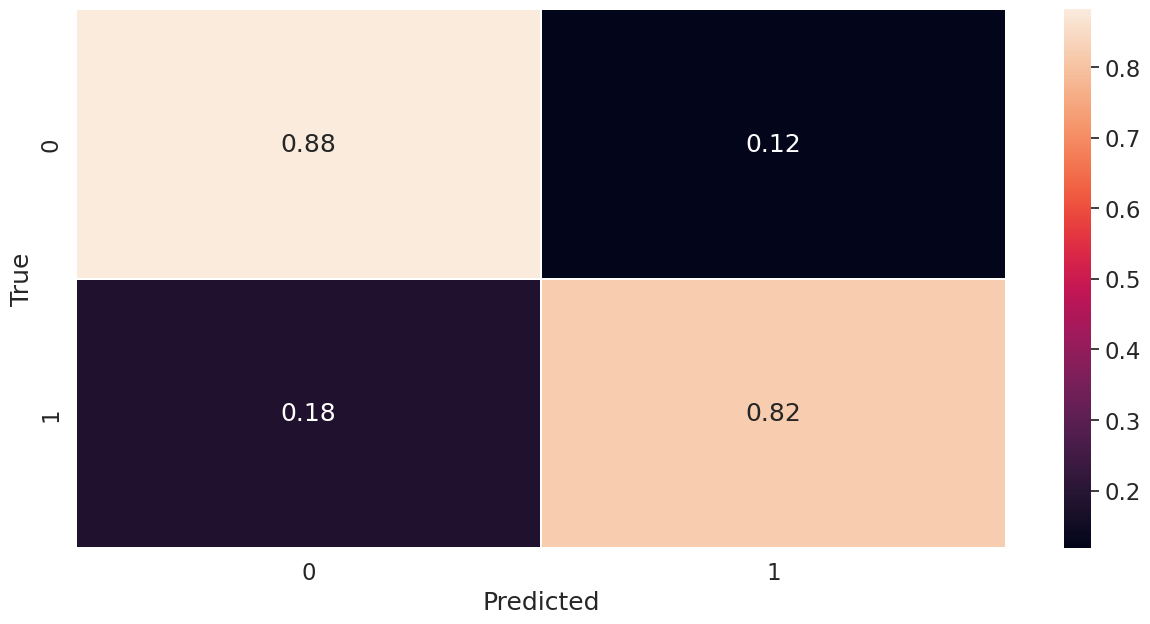

In [ ]:
# confusion matrix

cm = confusion_matrix(classes, pred_classes, normalize='true')

fif, ax = plt.subplots(figsize=(15,7))
sns.heatmap(cm, annot=True, linewidths=.1, xticklabels=list(labels_map.values()), yticklabels=list(labels_map.values()), ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")

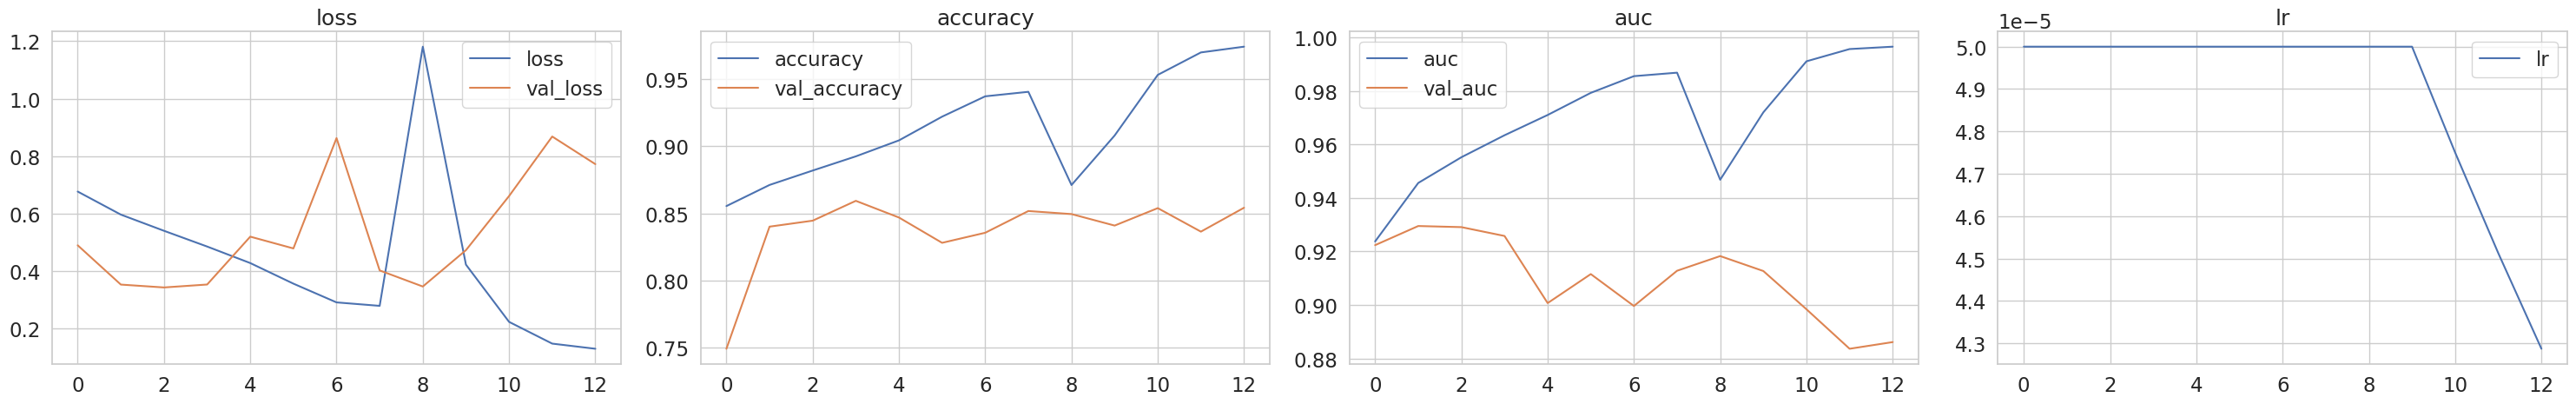

In [ ]:
plot_history(history.history)

# EFFICIENT NET

We now want to compare our results obtained with ResNet50 with the ones of Efficient Net, a neural network we used in our laboratory lessons to develop a transfer learning model.

Also in this case, we use the images with dimensions reduced from 224x224 pixels to 50x50 pixels, as the ones in the original code.

In [ ]:
# import pre-trained network and its preprocessing function
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2S

We now create the second NN using a pretrained Efficient Net Network as backbone.

In [ ]:
def transfer_learning_network(input_shape, num_class=2):

    inputs = layers.Input(input_shape)
    x = data_augmentation(inputs)

    # load the pretrained net, without the final layers
    # (in this case the preprocessing is inlcuded in the model
    # otherwise, you should add here the correct preprocessing function)
    backbone = EfficientNetV2S(include_top=False, input_tensor=x, weights="imagenet", include_preprocessing=True)
    #include prerpocessing set to false if you did the preprocessing before(here done in data augmentation)
    #include top is the classification part...we rmove it to do OUR classificiation
    # freeze pretrained network
    backbone.trainable = False #doesn't have to update the backbone which is already trained

    # add top for fine tuning for our specific task
    # (you usually have a Global...Pooling layer here)
    x = layers.GlobalAveragePooling2D()(backbone.output)
    x = layers.Dropout(.25)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(.25)(x)
    # in case of binary classification here I can just have 1 unit with sigmoid activation
    if num_class == 2:
        out = layers.Dense(1, activation="sigmoid")(x)
    else:
        out = layers.Dense(num_class, activation="softmax")(x)

    # create the whole model (pretrained ResNet + custom head)
    model = keras.Model(inputs=inputs, outputs=out)

    return model

In [ ]:
t2_model = transfer_learning_network(input_shape, num_class=2)
t2_model.summary()

82420632/82420632 [==============================] - 3s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 50, 50, 3)]          0         []                            
                                                                                                  
 sequential_1 (Sequential)   (None, 50, 50, 3)            0         ['input_2[0][0]']             
                                                                                                  
 rescaling_1 (Rescaling)     (None, 50, 50, 3)            0         ['sequential_1[1][0]']        
                                                                                                  
 stem_conv (Conv2D)          (None, 25, 25, 24)           648       ['rescaling_1[0][0]']         
                           

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.570864 to fit



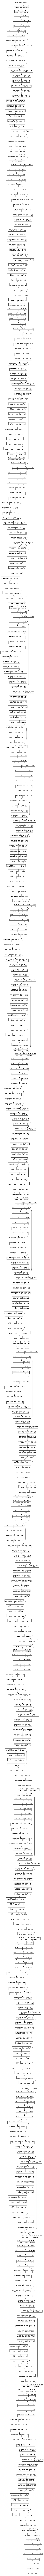

In [ ]:
keras.utils.plot_model(t2_model, to_file="transfer_learning.png", show_shapes=True)

The following lines of code follow the same modus operandi used above for the ResNet50 model.

In [ ]:
t2_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=metrics)
history = t2_model.fit(train_ds, epochs=20, callbacks=callbacks, validation_data=val_ds, class_weight=weights)

Epoch 1/20
3002/3002 [==============================] - 102s 29ms/step - loss: 0.9471 - accuracy: 0.7836 - auc: 0.8547 - val_loss: 0.4551 - val_accuracy: 0.7972 - val_auc: 0.8767 - lr: 0.0010
Epoch 2/20
3002/3002 [==============================] - 84s 28ms/step - loss: 0.9100 - accuracy: 0.7949 - auc: 0.8691 - val_loss: 0.4426 - val_accuracy: 0.8050 - val_auc: 0.8842 - lr: 0.0010
Epoch 3/20
3002/3002 [==============================] - 84s 28ms/step - loss: 0.8991 - accuracy: 0.7982 - auc: 0.8728 - val_loss: 0.4224 - val_accuracy: 0.8148 - val_auc: 0.8800 - lr: 0.0010
Epoch 4/20
3002/3002 [==============================] - 84s 28ms/step - loss: 0.8878 - accuracy: 0.8003 - auc: 0.8759 - val_loss: 0.4387 - val_accuracy: 0.8065 - val_auc: 0.8816 - lr: 0.0010
Epoch 5/20
3002/3002 [==============================] - 86s 29ms/step - loss: 0.8876 - accuracy: 0.8014 - auc: 0.8762 - val_loss: 0.4567 - val_accuracy: 0.7894 - val_auc: 0.8850 - lr: 0.0010
Epoch 6/20
3002/3002 [======================

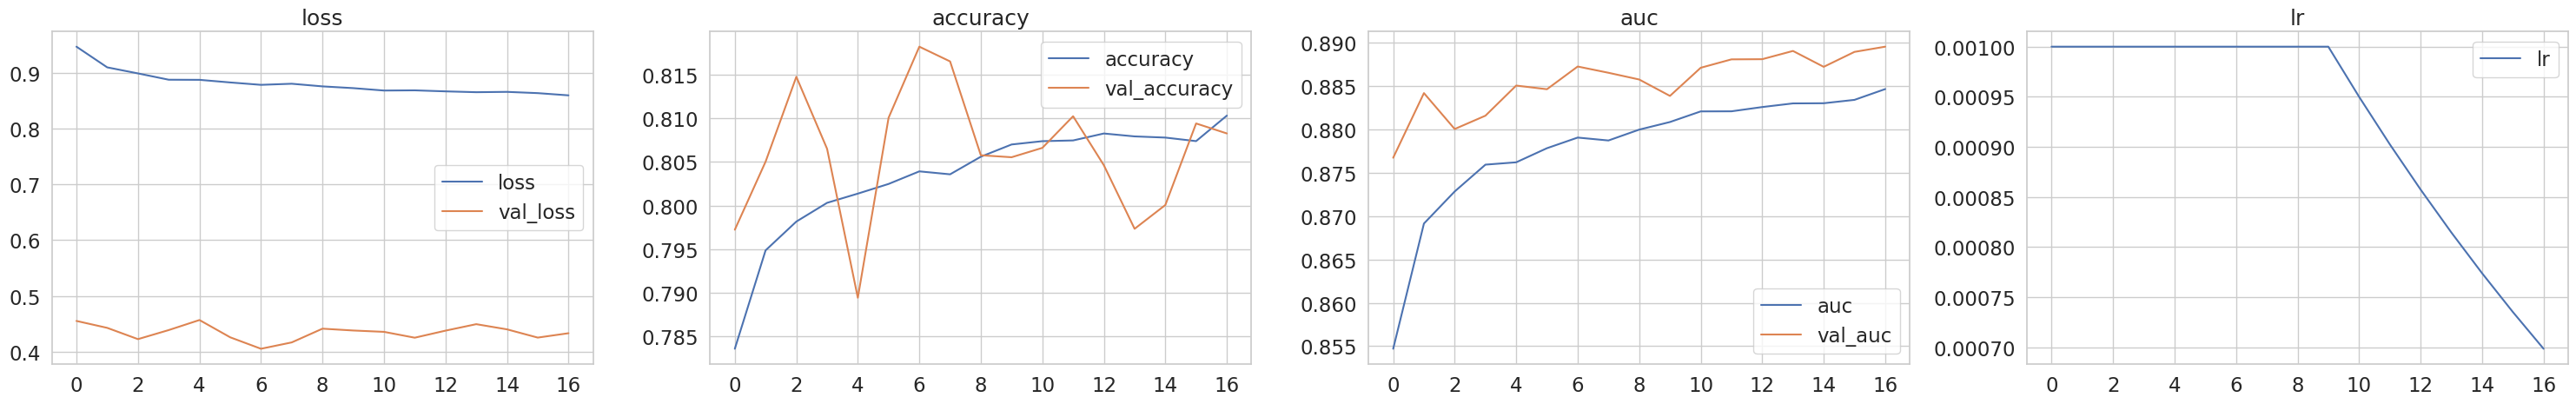

In [ ]:
plot_history(history.history)

In [ ]:
t2_model.evaluate(val_ds)

888/888 [==============================] - 24s 27ms/step - loss: 0.4052 - accuracy: 0.8182 - auc: 0.8872


[0.405155748128891, 0.8182138204574585, 0.8872172832489014]

In [ ]:
t2_model.save("models/TL_20epoch_EfficientNet_Size50_OB.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Predictions on test set using EfficientNet



In [ ]:
imgs, labels, preds = [], [], []

for img, label in test_set:
    pred = t2_model.predict(img)

    imgs.append(img.numpy())
    labels.append(label.numpy())
    preds.append(pred)


2/2 [==============================] - 4s 484ms/step


In [ ]:
# predictions are done in batches
imgs[0].shape

(64, 50, 50, 3)

In [ ]:
# concatenate arrays
imgs = np.concatenate(imgs).astype(np.uint8)
labels = np.concatenate(labels).squeeze()
preds = np.concatenate(preds).squeeze()

In [ ]:
classes = labels
pred_classes=np.zeros(shape=(len(preds),1),dtype=np.int8).squeeze()
pred_classes[preds>0.5] = int(1)


In [ ]:
# compute some metrics using sklearn

print(
    classification_report(
        classes, pred_classes,
        labels=list(labels_map.keys()),
        target_names=list(labels_map.values()), digits=3
    )
)

              precision    recall  f1-score   support

           0      0.873     0.880     0.876     19977
           1      0.717     0.704     0.710      8624

    accuracy                          0.827     28601
   macro avg      0.795     0.792     0.793     28601
weighted avg      0.826     0.827     0.826     28601



Text(145.75, 0.5, 'True')

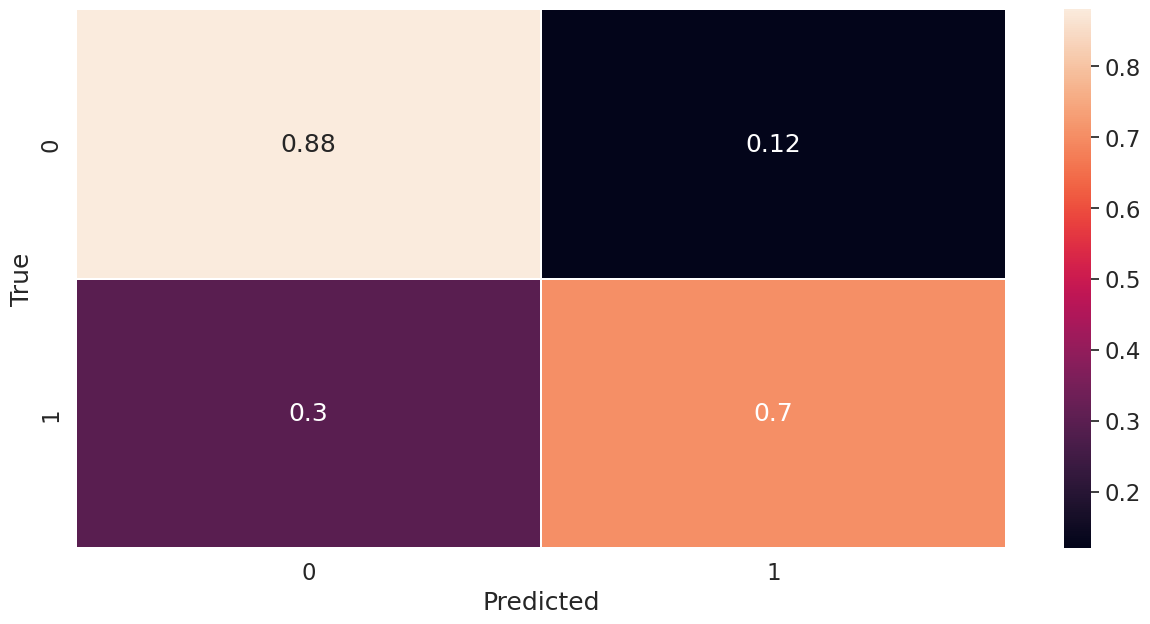

In [ ]:
# confusion matrix

cm = confusion_matrix(classes, pred_classes,normalize='true')

fif, ax = plt.subplots(figsize=(15,7))
sns.heatmap(cm, annot=True, linewidths=.1, xticklabels=list(labels_map.values()), yticklabels=list(labels_map.values()), ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")

888/888 [==============================] - 24s 27ms/step - loss: 0.4052 - accuracy: 0.8182 - auc: 0.8872


[0.40515607595443726, 0.8182138204574585, 0.8872172832489014]

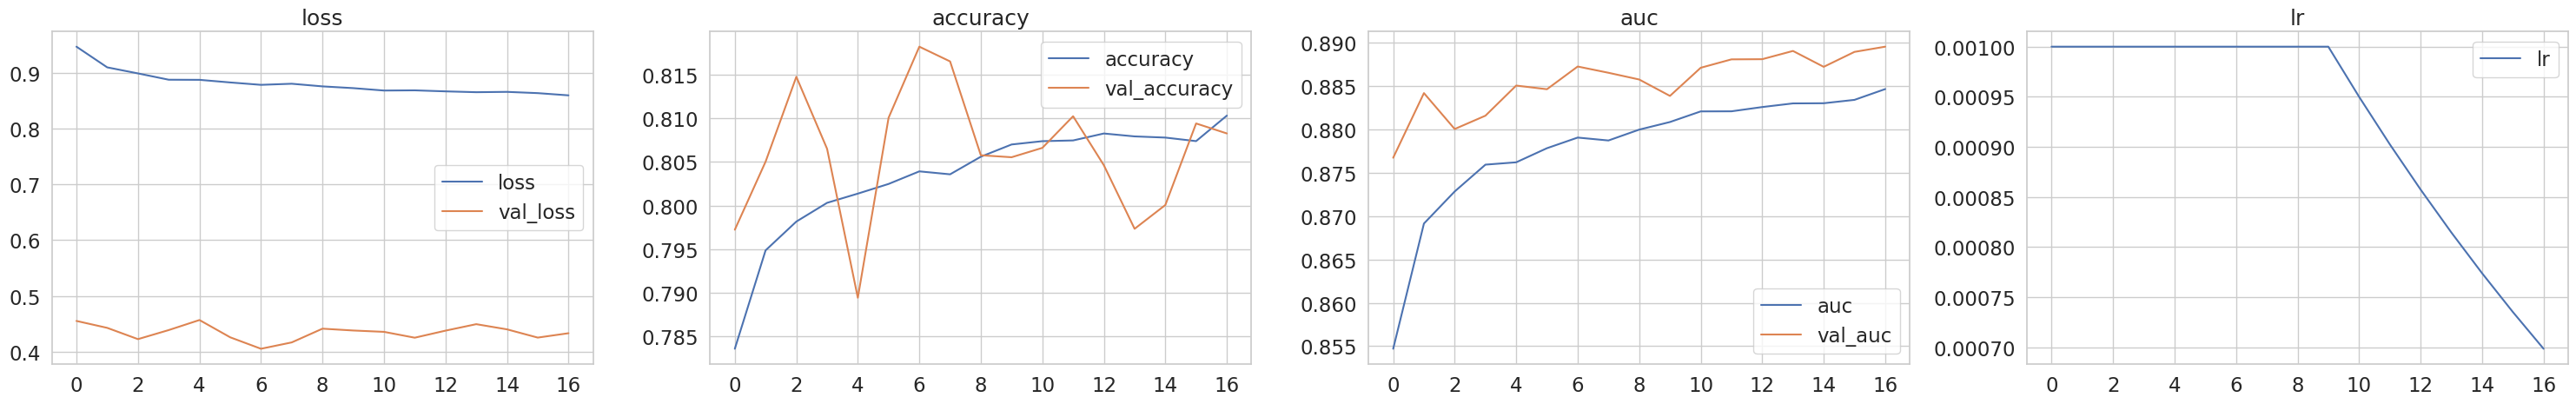

In [ ]:
plot_history(history.history)

t2_model.evaluate(val_ds)

In [ ]:
# plot some misclassified elements

wrong_idx =np.argwhere(classes!=pred_classes)
print(len(wrong_idx))

4954


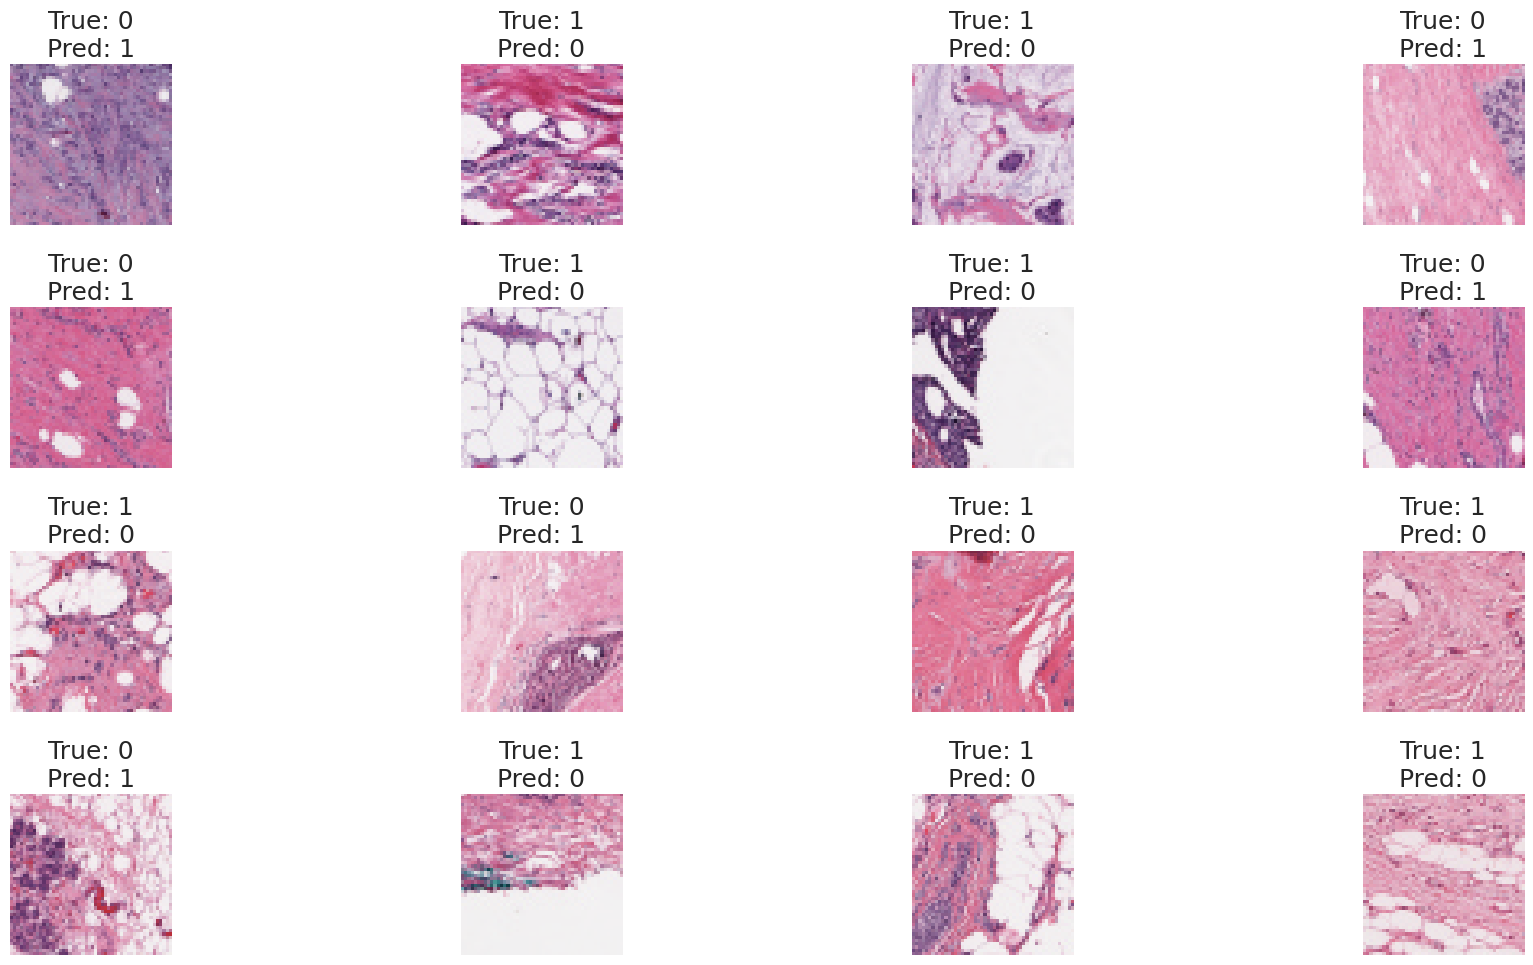

In [ ]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(20, 10))

for idx, ax in zip(wrong_idx, axs.flatten()):
    ax.imshow(imgs[idx[0]])
    true_label = str(int(classes[idx[0]]))
    pred_label = str(pred_classes[idx[0]])
    ax.set_title(f"True: {true_label}\nPred: {pred_label}")
    ax.axis("off")

fig.tight_layout()

# Unfreeze of the Efficient Net parameters
Now we unfreeze the pretrained backbone and do some more epochs with a very low learning rate to see if we can get an improvement. We follow the same modus operandi as before with the ResNet50 unfreezed model.

In [ ]:
# unfreeze model
for layer in t2_model.layers:
  if not isinstance(layer, layers.BatchNormalization):
    layer.trainable = True

optimizer = tf.keras.optimizers.Adam(learning_rate=0.5e-4)
t2_model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=metrics)

In [ ]:
history = t2_model.fit(train_ds, epochs=20, validation_data=val_ds, class_weight=weights, callbacks=callbacks)

Epoch 1/20
3002/3002 [==============================] - 297s 84ms/step - loss: 0.7019 - accuracy: 0.8508 - auc: 0.9169 - val_loss: 0.3198 - val_accuracy: 0.8567 - val_auc: 0.9269 - lr: 5.0000e-05
Epoch 2/20
3002/3002 [==============================] - 248s 83ms/step - loss: 0.6195 - accuracy: 0.8687 - auc: 0.9414 - val_loss: 0.3269 - val_accuracy: 0.8679 - val_auc: 0.9245 - lr: 5.0000e-05
Epoch 3/20
3002/3002 [==============================] - 249s 83ms/step - loss: 0.5880 - accuracy: 0.8760 - auc: 0.9472 - val_loss: 0.3088 - val_accuracy: 0.8669 - val_auc: 0.9297 - lr: 5.0000e-05
Epoch 4/20
3002/3002 [==============================] - 248s 83ms/step - loss: 0.5656 - accuracy: 0.8798 - auc: 0.9511 - val_loss: 0.3220 - val_accuracy: 0.8584 - val_auc: 0.9257 - lr: 5.0000e-05
Epoch 5/20
3002/3002 [==============================] - 249s 83ms/step - loss: 0.5462 - accuracy: 0.8848 - auc: 0.9544 - val_loss: 0.3297 - val_accuracy: 0.8633 - val_auc: 0.9242 - lr: 5.0000e-05
Epoch 6/20
3002/3002

In [ ]:
imgs, labels, preds = [], [], []



for img, label in test_set:
    pred = t2_model.predict(img)

    imgs.append(img.numpy())
    labels.append(label.numpy())
    preds.append(pred)


2/2 [==============================] - 3s 23ms/step


In [ ]:
# predictions are done in batches
imgs[0].shape

(64, 50, 50, 3)

In [ ]:
# concatenate arrays
imgs = np.concatenate(imgs).astype(np.uint8)
labels = np.concatenate(labels).squeeze()
preds = np.concatenate(preds).squeeze()

In [ ]:
classes = labels
pred_classes=np.zeros(shape=(len(preds),1),dtype=np.int8).squeeze()
pred_classes[preds>0.5] = int(1)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# compute some metrics using sklearn

print(
    classification_report(
        classes, pred_classes,
        labels=list(labels_map.keys()),
        target_names=list(labels_map.values()), digits=3
    )
)

              precision    recall  f1-score   support

           0      0.904     0.922     0.913     19977
           1      0.811     0.772     0.791      8624

    accuracy                          0.877     28601
   macro avg      0.857     0.847     0.852     28601
weighted avg      0.876     0.877     0.876     28601



Text(145.75, 0.5, 'True')

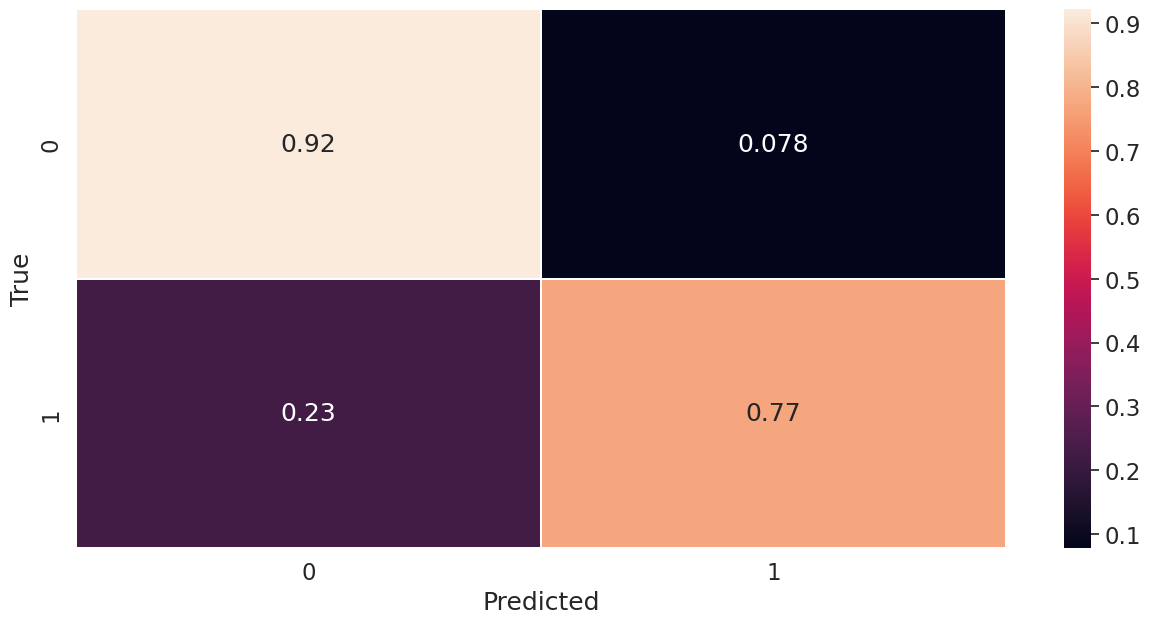

In [ ]:
# confusion matrix

cm = confusion_matrix(classes, pred_classes, normalize='true')

fif, ax = plt.subplots(figsize=(15,7))
sns.heatmap(cm, annot=True, linewidths=.1, xticklabels=list(labels_map.values()), yticklabels=list(labels_map.values()), ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")

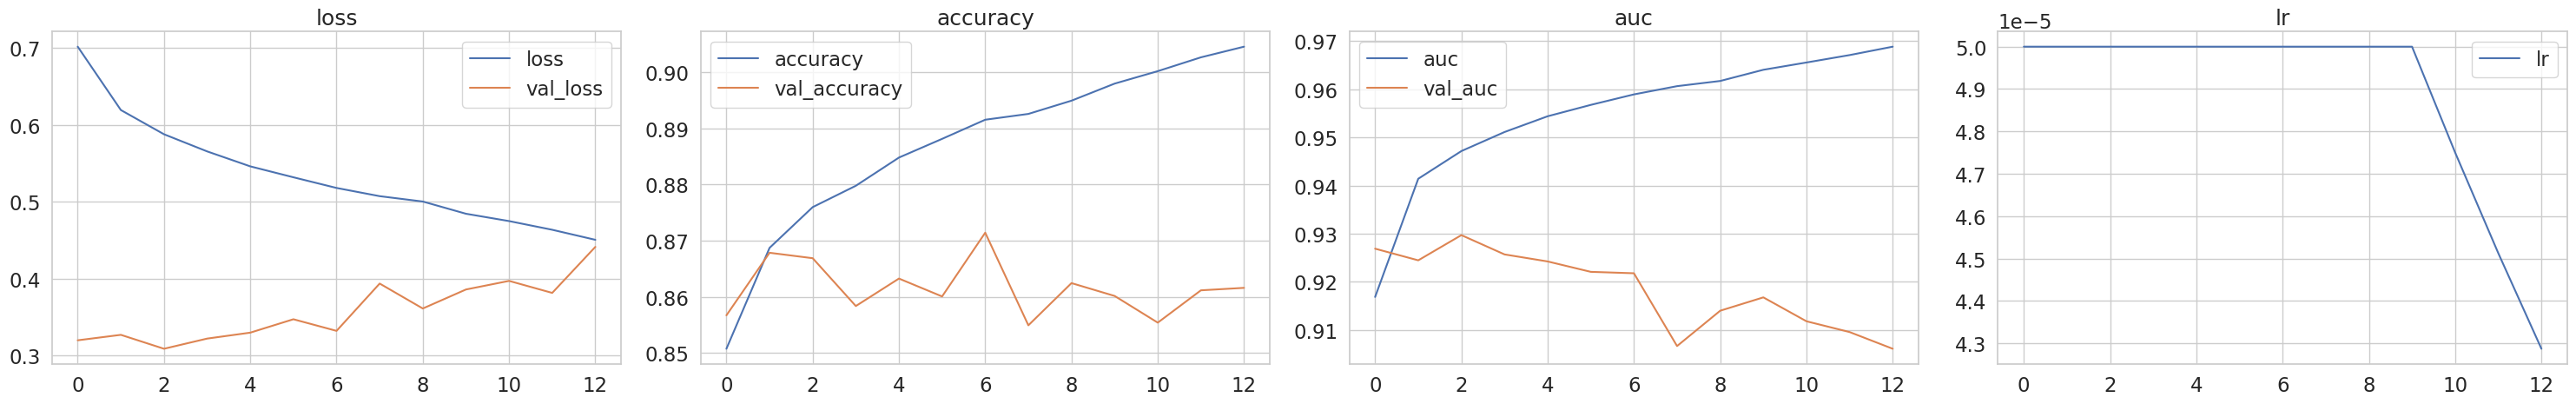

In [ ]:
plot_history(history.history)

In [ ]:
t2_model.evaluate(val_ds)

888/888 [==============================] - 24s 27ms/step - loss: 0.3088 - accuracy: 0.8669 - auc: 0.9297


[0.30876991152763367, 0.8668908476829529, 0.9297041893005371]

In [ ]:
t2_model.save("models/TL_20epoch_EfficientNet_Size50_OB_unfrozen.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
